In [706]:
import numpy as np, pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt, seaborn as sns
import scipy
import warnings
import plotly.express as px
from itertools import product
import statsmodels.api as sm
import datetime
from tqdm import tqdm
import os
import math

df = pd.read_csv(os.path.join(
    os.getcwd(), 
    "data", 
    "country_vaccinations.csv"))

In [707]:
def PrintColumns(df, info=""):
    print(f"Dataset {info} contain columns:")
    for col in df.columns:
        print("\t" + col)
        
def dropColumn(df, column):
    del df[column]
    return df

In [708]:
PrintColumns(df, info="before removing")
df = dropColumn(df, "source_name")
df = dropColumn(df, "source_website")
PrintColumns(df, info="after removing")

Dataset before removing contain columns:
	country
	iso_code
	date
	total_vaccinations
	people_vaccinated
	people_fully_vaccinated
	daily_vaccinations_raw
	daily_vaccinations
	total_vaccinations_per_hundred
	people_vaccinated_per_hundred
	people_fully_vaccinated_per_hundred
	daily_vaccinations_per_million
	vaccines
	source_name
	source_website
Dataset after removing contain columns:
	country
	iso_code
	date
	total_vaccinations
	people_vaccinated
	people_fully_vaccinated
	daily_vaccinations_raw
	daily_vaccinations
	total_vaccinations_per_hundred
	people_vaccinated_per_hundred
	people_fully_vaccinated_per_hundred
	daily_vaccinations_per_million
	vaccines


In [709]:
def getNotValidISOCodes():
    for code in df.iso_code.unique():
        if len(code) != 3:
            yield code

            
def getCountryFromISO(code):
    return df[code == df.iso_code].country.iloc[0]
    

def getNotValidCountries():
    for code in getNotValidISOCodes():
        country = getCountryFromISO(code) 
        yield (country, code)

        
for country in getNotValidCountries():
    name, code = country
    print(f"{name} has code {code}")

England has code OWID_ENG
Kosovo has code OWID_KOS
Northern Cyprus has code OWID_CYN
Northern Ireland has code OWID_NIR
Scotland has code OWID_SCT
Wales has code OWID_WLS


In [710]:
uk_code = 'GBR'
cyprus_code = 'CYP'
kosovo_code = 'XKX'
uk_name = getCountryFromISO(uk_code)
cyprus_name = getCountryFromISO(cyprus_code)

def swapValuesInColumn(old, new):
    global df
    df = df.replace(old, new) 

    
# change code for kosovo
swapValuesInColumn('OWID_KOS', kosovo_code)

# join nothern cyprus into "classic" cyprus
swapValuesInColumn('OWID_CYN', cyprus_code)
swapValuesInColumn('Northern Cyprus', cyprus_name)

# merge rest of countries to UK
for region in getNotValidCountries():
    name, code = region
    print(f"Join {name} ({code}) into UK")
    swapValuesInColumn(code, uk_code)
    swapValuesInColumn(name, uk_name)

Join England (OWID_ENG) into UK
Join Northern Ireland (OWID_NIR) into UK
Join Scotland (OWID_SCT) into UK
Join Wales (OWID_WLS) into UK


In [711]:
print(f"Size of data is: {df.shape}")
print(f"Missing values in dataset: \n{df.isna().sum()}")

Size of data is: (13307, 13)
Missing values in dataset: 
country                                   0
iso_code                                  0
date                                      0
total_vaccinations                     5390
people_vaccinated                      6069
people_fully_vaccinated                8069
daily_vaccinations_raw                 6685
daily_vaccinations                      226
total_vaccinations_per_hundred         5390
people_vaccinated_per_hundred          6069
people_fully_vaccinated_per_hundred    8069
daily_vaccinations_per_million          226
vaccines                                  0
dtype: int64


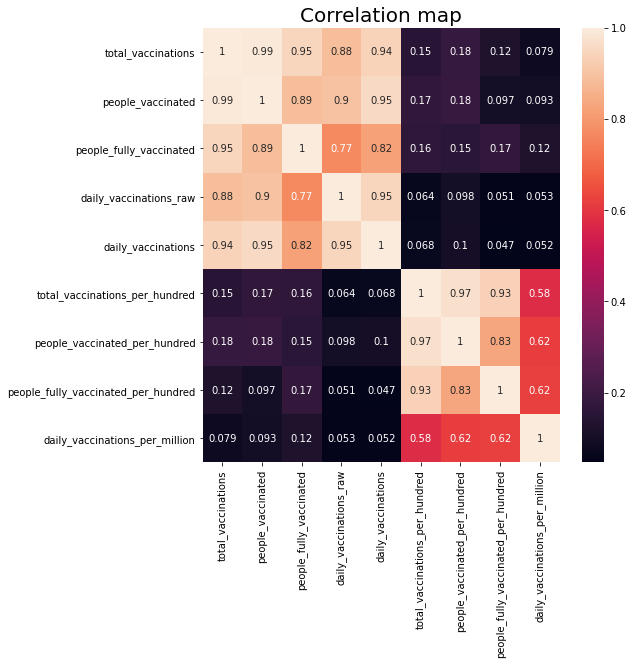

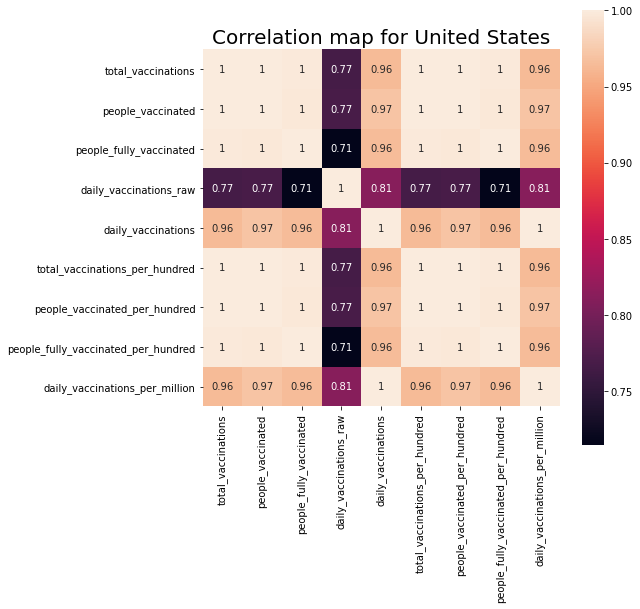

In [712]:
def makeHeatMap():
    plt.subplots(figsize=(8, 8))
    sns.heatmap(df.corr(), annot=True)
    plt.title("Correlation map", fontsize=20)
    plt.show()
    

def makeCorrHeatMapFrom(country):
    data = df.loc[df['country'] == country]
    plt.subplots(figsize=(8, 8))
    sns.heatmap(data.corr(), annot=True, square=True)
    plt.title(f"Correlation map for {country}", fontsize=20)
    plt.show()
    

makeHeatMap()
makeCorrHeatMapFrom('United States')

In [713]:
def getCorrInCountryBetween(attr1, attr2, country):  
    data = df.loc[df['country'] == country]
    data = data[[attr1, attr2]]
    res = data.corr()
    res = round(res.loc[attr1, attr2], 2)
    return res


def getCorrInCountries(attr1, attr2):
    corrs = []
    for country in df.country.unique():
        corr = getCorrInCountryBetween(attr1, attr2, country)
        if corr:
            corrs.append(corr)
    return corrs
    

def makeCorrHistogram(attr1, attr2):
    correlations = getCorrInCountries(attr1, attr2)
    counts, bins, bars = plt.hist(correlations, bins=5)
    plt.title(f"Correlation between:\n{attr1}\nand\n{attr2}", fontsize=20)
    plt.xlabel("Values of correlations", fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.xticks(bins)
    plt.show()


# makeCorrHistogram('daily_vaccinations', 'daily_vaccinations_per_million')
# makeCorrHistogram('people_fully_vaccinated', 'people_fully_vaccinated_per_hundred')
# makeCorrHistogram('people_vaccinated', 'people_vaccinated_per_hundred')
# makeCorrHistogram('total_vaccinations', 'total_vaccinations_per_hundred')

In [714]:
def getDataToFillTotalVaccIn(country):
    df.loc[df['country'] == country]
    df['total_vaccinations'] = df['total_vaccinations'].interpolate()
    return df

def fillTotalVacc():
    global df
    print(f"Missing values before fill: \n{df.isna().sum()}")  
    for country in df.country.unique():
        df = getDataToFillTotalVaccIn(country)
    print(f"Missing values after fill: \n{df.isna().sum()}")


dropColumn(df, 'daily_vaccinations_raw')
fillTotalVacc()

Missing values before fill: 
country                                   0
iso_code                                  0
date                                      0
total_vaccinations                     5390
people_vaccinated                      6069
people_fully_vaccinated                8069
daily_vaccinations                      226
total_vaccinations_per_hundred         5390
people_vaccinated_per_hundred          6069
people_fully_vaccinated_per_hundred    8069
daily_vaccinations_per_million          226
vaccines                                  0
dtype: int64
Missing values after fill: 
country                                   0
iso_code                                  0
date                                      0
total_vaccinations                        0
people_vaccinated                      6069
people_fully_vaccinated                8069
daily_vaccinations                      226
total_vaccinations_per_hundred         5390
people_vaccinated_per_hundred          6069
people

In [715]:
def getNumberOfPeopleIn(country):
    num = []
    for index, row in df.loc[df['country'] == country].iterrows():
        relative = row['total_vaccinations_per_hundred']
        absolute = row['total_vaccinations']
        if not pd.isna(df.at[index, 'total_vaccinations_per_hundred']) and relative != 0:
            num.append(absolute / relative)
    if len(num) < 1:
        return absolute
    else:
        return int(sum(num) / len(num)) * 100


def updateRelativeVaccIn(country):
    people = getNumberOfPeopleIn(country)
    for index, row in df.loc[df['country'] == country].iterrows():
        if pd.isna(df.at[index, 'total_vaccinations_per_hundred']):
            absolute = row['total_vaccinations']
            new_value = absolute*100 / people
            df.at[index, 'total_vaccinations_per_hundred'] = new_value
    
    
print(f"Missing values after fill: \n{df.isna().sum()}")
for country in df.country.unique():
    updateRelativeVaccIn(country)
print(f"Missing values after fill: \n{df.isna().sum()}")

Missing values after fill: 
country                                   0
iso_code                                  0
date                                      0
total_vaccinations                        0
people_vaccinated                      6069
people_fully_vaccinated                8069
daily_vaccinations                      226
total_vaccinations_per_hundred         5390
people_vaccinated_per_hundred          6069
people_fully_vaccinated_per_hundred    8069
daily_vaccinations_per_million          226
vaccines                                  0
dtype: int64
Missing values after fill: 
country                                   0
iso_code                                  0
date                                      0
total_vaccinations                        0
people_vaccinated                      6069
people_fully_vaccinated                8069
daily_vaccinations                      226
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred          6069
people_